In [2]:
#import
import numpy as np 
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import seaborn as sns
import random
from gymnasium import Env, spaces

Using device: cuda
Starting training...
Episode 1000/10000, Avg Reward (Last 10): 55.50, Epsilon: 0.667
Model saved to football_models/agent_0_episode_1000.pt
Model saved to football_models/agent_1_episode_1000.pt
Model saved to football_models/agent_2_episode_1000.pt
Episode 2000/10000, Avg Reward (Last 10): 78.50, Epsilon: 0.494
Model saved to football_models/agent_0_episode_2000.pt
Model saved to football_models/agent_1_episode_2000.pt
Model saved to football_models/agent_2_episode_2000.pt
Episode 3000/10000, Avg Reward (Last 10): 76.50, Epsilon: 0.366
Model saved to football_models/agent_0_episode_3000.pt
Model saved to football_models/agent_1_episode_3000.pt
Model saved to football_models/agent_2_episode_3000.pt
Episode 4000/10000, Avg Reward (Last 10): 75.50, Epsilon: 0.271
Model saved to football_models/agent_0_episode_4000.pt
Model saved to football_models/agent_1_episode_4000.pt
Model saved to football_models/agent_2_episode_4000.pt
Episode 5000/10000, Avg Reward (Last 10): 80

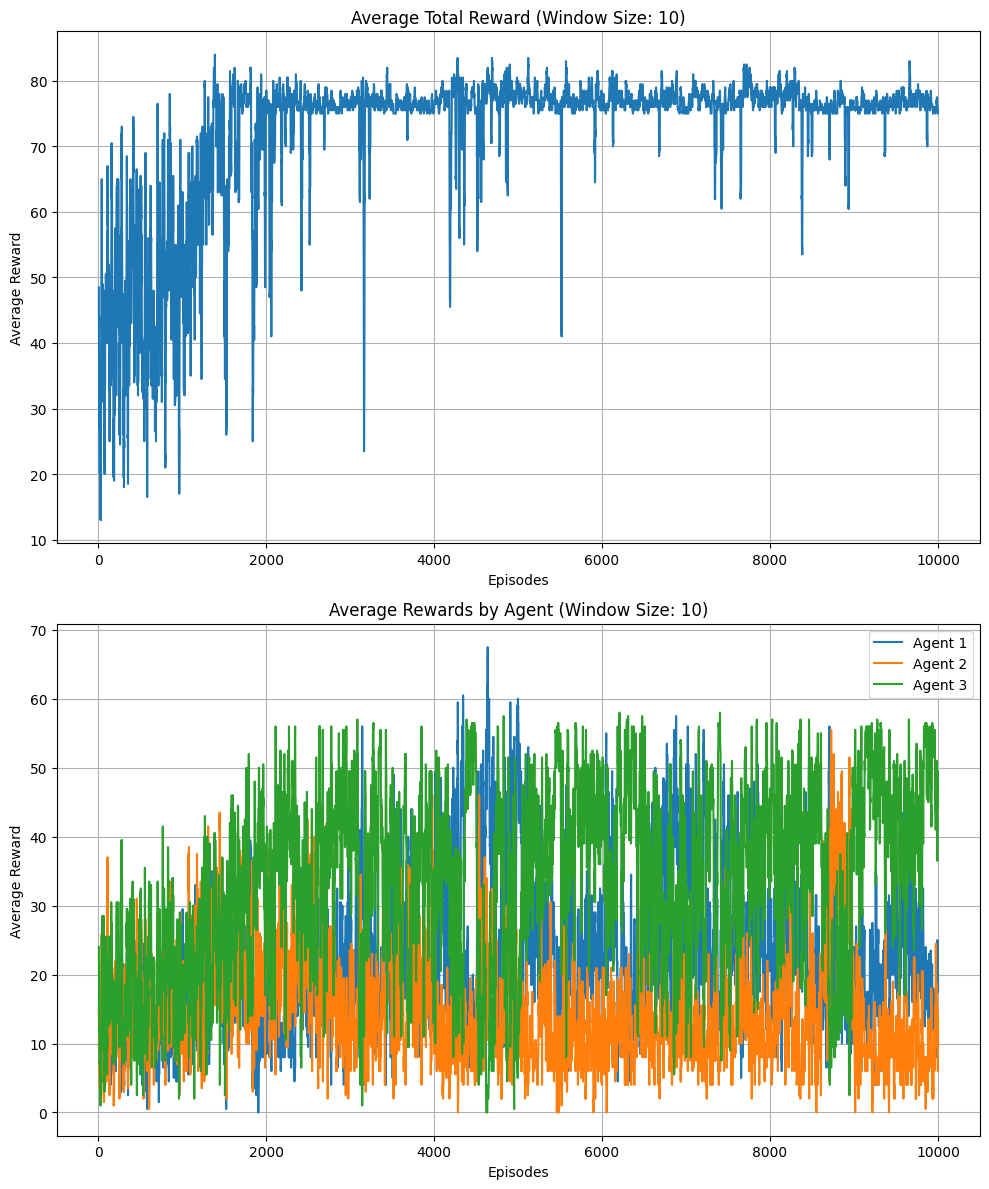

Evaluating trained agents and creating GIF...
Evaluation Episode 1/1
Episode 1 rewards: [3.3333333333333335, 0.0, 9.166666666666666]
Saving GIF to football_evaluation.gif with 6 frames at 20 fps...
GIF saved successfully to football_evaluation.gif
Final evaluation - Average rewards per agent: [3.33333333 0.         9.16666667]
GIF saved to football_evaluation.gif
Models saved to football_models/


In [12]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from gym import Env, spaces
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from PIL import Image
import io

def evaluate_actor_critic_agents(env, episodes=5, max_steps=100, render=True, sleep_time=0.1, save_gif=False, gif_path='football_evaluation.gif', fps=5):
    """
    Evaluate the performance of actor-critic agents in the football environment.
    
    Args:
        env: FootballEnv instance
        episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment
        sleep_time: Delay between renders (in seconds)
        save_gif: Whether to save the evaluation as a GIF
        gif_path: Path to save the GIF
        fps: Frames per second for the GIF
        
    Returns:
        avg_rewards: Average rewards for each agent
    """
    episode_rewards = []
    frames = [] if save_gif else None
    
    for episode in range(episodes):
        print(f"Evaluation Episode {episode+1}/{episodes}")
        
        # Reset environment with a new random ball position
        state = env.reset()
        
        # Ensure ball doesn't start at an agent's position
        ball_pos_valid = False
        while not ball_pos_valid:
            ball_pos_valid = True
            for agent_pos in env.agents_positions:
                if np.array_equal(env.ball_pos, agent_pos):
                    # Respawn ball if it's at an agent's position
                    env.ball_pos = np.array([
                        np.random.randint(0, env.field_height),
                        np.random.randint(0, env.field_width)
                    ])
                    ball_pos_valid = False
                    break
        
        # Initialize episode variables
        total_rewards = [0.0 for _ in env.agents]
        done = False
        steps = 0
        target_agent_index = None  # Track which agent is the target of a pass
        
        # Run episode
        while not done and steps < max_steps:
            # Render environment if requested
            if render:
                env.render()
                time.sleep(sleep_time)
            
            # Capture frame for GIF if requested
            if save_gif:
                frame = env.render_rgb()
                frames.append(frame)
            
            # Get actions with no exploration (evaluate=True)
            actions = []
            for i, agent in enumerate(env.agents):
                # Force target agent to stay still if ball is in transit
                if env.ball_in_transit and i == target_agent_index:
                    action = 9  # Stay still
                else:
                    # Get action with no exploration (epsilon=0)
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                    with torch.no_grad():
                        action_probs, _ = agent.network(state_tensor)
                        action = torch.argmax(action_probs).item()
                actions.append(action)
                    
            # Execute actions in environment
            next_state, rewards, done, _ = env.step(actions)
            
            # Update target agent if a pass occurred
            if not env.ball_in_transit and target_agent_index is not None:
                target_agent_index = None
                
            # If a pass action was taken, identify the target agent
            for i, action in enumerate(actions):
                if action == 8 and env.ball_holder == i:  # Agent attempted to pass
                    target_agent_index = env.closest_pass()
                    break
            
            # Accumulate rewards
            for i, reward in enumerate(rewards):
                total_rewards[i] += reward
            
            state = next_state
            steps += 1
        
        # Calculate average reward per step for each agent
        avg_episode_rewards = [total / max(1, steps) for total in total_rewards]
        print(f"Episode {episode+1} rewards: {avg_episode_rewards}")
        episode_rewards.append(avg_episode_rewards)
    
    # Save GIF if requested
    if save_gif and frames:
        save_frames_as_gif(frames, gif_path, fps)
    
    # Calculate overall average rewards across episodes
    avg_rewards = np.mean(episode_rewards, axis=0)
    return avg_rewards

def save_frames_as_gif(frames, path, fps=5):
    """
    Save a list of frames as a GIF
    
    Args:
        frames: List of PIL Image frames
        path: Path to save the GIF
        fps: Frames per second
    """
    print(f"Saving GIF to {path} with {len(frames)} frames at {fps} fps...")
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
    
    # Save frames as GIF
    frames[0].save(
        path,
        format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=int(1000/fps),  # Duration in milliseconds
        loop=0  # Loop forever
    )
    print(f"GIF saved successfully to {path}")

def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

class ActorCritic(nn.Module):
    def __init__(self, input_size, action_size):
        super(ActorCritic, self).__init__()
        
        # Deeper network
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        
        # Actor (policy) layers
        self.actor_fc = nn.Linear(256, 128)
        self.actor_out = nn.Linear(128, action_size)
        
        # Critic (value) layers
        self.critic_fc = nn.Linear(256, 128)
        self.critic_out = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Actor head
        actor_hidden = F.relu(self.actor_fc(x))
        action_probs = F.softmax(self.actor_out(actor_hidden), dim=-1)
        
        # Critic head
        critic_hidden = F.relu(self.critic_fc(x))
        state_value = self.critic_out(critic_hidden)
        
        return action_probs, state_value

class Agent:
    def __init__(self, field_height, field_width, state_size, pos=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.field_height = field_height
        self.field_width = field_width
        self.action_space = spaces.Discrete(10)  # 8 moves + pass + stay still
        self.pos = pos
        self.position = np.array(pos) if pos is not None else np.array([
            np.random.randint(0, field_height),
            np.random.randint(0, field_width)
        ])
        self.pass_speed = 4
        self.pass_speed_decay = 1
        self.device = device
        
        # Actor-Critic network
        self.network = ActorCritic(state_size, self.action_space.n).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        
        # Memory for storing experience
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.log_probs = []
        self.values = []

    def reset_position(self):
        if self.pos is None:
            self.position = np.array([
                np.random.randint(0, self.field_height),
                np.random.randint(0, self.field_width)
            ])
        return self.position
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.log_probs = []
        self.values = []

    def pass_ball(self, current_position, target_position):
        """
        Calculate ball trajectory using Bresenham's line algorithm.
        
        :param current_position: Current ball position (x, y)
        :param target_position: Target position for pass (x, y)
        :return: ball trajectory points, initial speed, and direction vector
        """
        # Convert positions to integers for Bresenham algorithm
        start_x, start_y = int(current_position[0]), int(current_position[1])
        target_x, target_y = int(target_position[0]), int(target_position[1])
        
        # Calculate trajectory points using Bresenham's algorithm
        trajectory_points = bresenham_line(start_x, start_y, target_x, target_y)
        
        # Skip the first point (current position)
        if len(trajectory_points) > 1:
            trajectory_points = trajectory_points[1:]
        
        # Calculate direction vector (normalized)
        direction = np.array([target_position[0] - current_position[0], 
                             target_position[1] - current_position[1]])
        direction_norm = np.linalg.norm(direction)
        
        if direction_norm > 0:
            direction = direction / direction_norm
        else:
            direction = np.array([0, 0])
        
        return trajectory_points, self.pass_speed, direction

    def get_action(self, state, epsilon=0.0):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_probs, state_value = self.network(state_tensor)
            dist = Categorical(action_probs)
            
            # Epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, self.action_space.n)
            else:
                action = dist.sample().item()
                
            log_prob = dist.log_prob(torch.tensor(action, device=self.device))
            
        # Store experience
        self.states.append(state_tensor)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(state_value)
        
        return action
    
    def learn(self, next_state, done, gamma=0.99):
        # Convert to tensor
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
        
        # Get value of next state
        _, next_value = self.network(next_state_tensor)
        next_value = next_value.detach().item()
        
        # Calculate returns and advantages
        returns = []
        advantages = []
        R = next_value if not done else 0
        
        for r, v in zip(reversed(self.rewards), reversed(self.values)):
            R = r + gamma * R
            returns.insert(0, R)
            advantage = R - v.item()
            advantages.insert(0, advantage)
        
        # Convert lists to tensors
        returns = torch.FloatTensor(returns).unsqueeze(1).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        old_states = torch.cat(self.states)
        old_actions = torch.LongTensor(self.actions).to(self.device)
        old_log_probs = torch.stack(self.log_probs)
        
        # Get current policy and values
        action_probs, values = self.network(old_states)
        dist = Categorical(action_probs)
        
        # Actor loss (policy gradient with advantage)
        new_log_probs = dist.log_prob(old_actions)
        actor_loss = -(new_log_probs * advantages).mean()
        
        # Critic loss (value function)
        critic_loss = F.mse_loss(values, returns)
        
        # Total loss
        loss = actor_loss + 0.5 * critic_loss
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Clear memory
        self.clear_memory()
        
        return loss.item()
    
    def save_model(self, path):
        """Save the agent's model"""
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(path) if os.path.dirname(path) else '.', exist_ok=True)
        
        # Save model
        torch.save({
            'model_state_dict': self.network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path):
        """Load the agent's model"""
        checkpoint = torch.load(path, map_location=self.device)
        self.network.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")

class FootballEnv(Env):
    def __init__(self, field_height, field_width, num_agents, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super(FootballEnv, self).__init__()

        self.field_height = field_height  # x-axis (rows)
        self.field_width = field_width  # y-axis (columns)
        self.goal_y = self.field_width - 1  # Goal at the far right (y-axis)
        self.device = device
        
        # State size: all agents' positions (x,y) + ball position (x,y) + ball holder info
        self.state_size = num_agents * 2 + 2 + 1
        
        # Create agents with actor-critic networks
        self.agents = [
            Agent(field_height, field_width, self.state_size, device=device) 
            for _ in range(num_agents)
        ]
        
        # Observation Space: continuous state space
        self.observation_space = spaces.Box(
            low=0, 
            high=max(field_height, field_width), 
            shape=(self.state_size,), 
            dtype=np.float32
        )

        self.rewards = np.full((self.field_height, self.field_width), -1, dtype=np.float32)
        
        self.ball_holder = None  # None: no one has the ball, 0: agent1, 1: agent2
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        
        # For reward tracking and plotting
        self.all_rewards = []
        self.agent_rewards = [[] for _ in range(num_agents)]
        
        self.reset()

    def reset(self, seed=None, options=None):
        self.agents_positions = [agent.reset_position() for agent in self.agents]
        
        # Spawn ball at random position
        self.ball_pos = np.array([
            np.random.randint(0, self.field_height), 
            np.random.randint(0, self.field_width)
        ])
        
        # Make sure ball doesn't spawn on an agent
        ball_pos_valid = False
        while not ball_pos_valid:
            ball_pos_valid = True
            for agent_pos in self.agents_positions:
                if np.array_equal(self.ball_pos, agent_pos):
                    # Respawn ball if it's at an agent's position
                    self.ball_pos = np.array([
                        np.random.randint(0, self.field_height),
                        np.random.randint(0, self.field_width)
                    ])
                    ball_pos_valid = False
                    break
        
        self.ball_holder = None
        self.ball_in_transit = False
        self.ball_transit_speed = 0
        self.ball_transit_direction = None
        self.ball_trajectory = []
        self.ball_trajectory_index = 0
        self.done = False
        
        # Return state
        return self._get_state()

    def _get_state(self):
        # Combine all agent positions, ball position, and ball holder into a single state vector
        state = []
        
        # Add all agent positions
        for pos in self.agents_positions:
            state.extend([pos[0] / self.field_height, pos[1] / self.field_width])  # Normalize
            
        # Add ball position
        state.extend([self.ball_pos[0] / self.field_height, self.ball_pos[1] / self.field_width])  # Normalize
        
        # Add ball holder info (-1 for no holder)
        state.append(-1.0 if self.ball_holder is None else self.ball_holder / len(self.agents))  # Normalize
        
        return np.array(state, dtype=np.float32)
    
    def closest_pass(self):
        # find the agent closest to the ball holder
        ball_holder_pos = self.agents_positions[self.ball_holder]
        distances = [np.linalg.norm(agent.position - ball_holder_pos) for agent in self.agents]
        # find agent closest to the ball other than the ball holder
        closest_agent = np.argmin([distances[i] if (i != self.ball_holder and distances[i] >= 3) else np.inf for i in range(len(distances))])
        return closest_agent
    
    def step(self, actions):
        rewards = [0] * len(self.agents)  # Initialize rewards

        # Define movement mapping for 8 directions
        move_map = {
            0: np.array([0, 1]),   # Right
            1: np.array([1, 1]),   # Down-Right
            2: np.array([1, 0]),   # Down
            3: np.array([1, -1]),  # Down-Left
            4: np.array([0, -1]),  # Left
            5: np.array([-1, -1]), # Up-Left
            6: np.array([-1, 0]),  # Up
            7: np.array([-1, 1])   # Up-Right
        }

        # Ball in transit logic
        if self.ball_in_transit and self.ball_trajectory:
            steps_to_move = min(self.ball_transit_speed, len(self.ball_trajectory) - self.ball_trajectory_index)

            for _ in range(steps_to_move):
                if self.ball_trajectory_index < len(self.ball_trajectory):
                    next_x, next_y = self.ball_trajectory[self.ball_trajectory_index]
                    self.ball_pos = np.array([next_x, next_y])
                    self.ball_trajectory_index += 1

                    # Check if any agent receives the ball
                    for i, agent in enumerate(self.agents):
                        if np.array_equal(agent.position, self.ball_pos):
                            self.ball_holder = i
                            self.ball_in_transit = False
                            rewards[i] += 20  # Reward for receiving a pass
                            rewards[self.last_passer] += 50  # Reward for successful pass

                            # End episode if the pass reaches the target
                            self.done = True
                            return self._get_state(), rewards, self.done, {}

                else:
                    self.ball_in_transit = False
                    break

            # Apply speed decay
            self.ball_transit_speed = max(0, self.ball_transit_speed - self.agents[0].pass_speed_decay)

            if self.ball_transit_speed == 0 or self.ball_trajectory_index >= len(self.ball_trajectory):
                self.ball_in_transit = False

        # Agent movements and actions
        for i, action in enumerate(actions):
            agent = self.agents[i]
            
            # Current position before movement
            old_position = agent.position.copy()

            if action in move_map:
                new_position = agent.position + move_map[action]
                new_position[0] = np.clip(new_position[0], 0, self.field_height - 1)
                new_position[1] = np.clip(new_position[1], 0, self.field_width - 1)
                agent.position = new_position
                self.agents_positions[i] = new_position

                # If this agent is holding the ball, update ball position
                if self.ball_holder == i and not self.ball_in_transit:
                    self.ball_pos = new_position.copy()

                # If agent moves to a position with the ball on the field
                if not self.ball_in_transit and np.array_equal(agent.position, self.ball_pos) and self.ball_holder is None:
                    self.ball_holder = i
                    rewards[i] += 5  # Picking up the ball

            elif action == 8:  # Passing
                if self.ball_holder == i and not self.ball_in_transit:
                    closest_pass = self.closest_pass()
                    target_agent_index = closest_pass
                    target_position = self.agents[target_agent_index].position
                    trajectory_points, pass_speed, pass_direction = agent.pass_ball(self.ball_pos, target_position)

                    self.ball_trajectory = [(int(x), int(y)) for x, y in trajectory_points]
                    self.ball_trajectory_index = 0

                    self.ball_in_transit = True
                    self.ball_transit_speed = pass_speed
                    self.ball_transit_direction = pass_direction
                    self.last_passer = i  # Store who made the pass
                    self.ball_holder = None

            elif action == 9:  # Stay still
                pass  # Do nothing

        return self._get_state(), rewards, self.done, {}

    def train(self, episodes, max_steps, epsilon_start=0.9, epsilon_end=0.05, epsilon_decay=0.9997, gamma=0.99, save_models=True, save_dir='models'):
        """
        Train the agents using the Actor-Critic algorithm
        
        Args:
            episodes: Number of training episodes
            max_steps: Maximum steps per episode
            epsilon_start: Starting exploration rate
            epsilon_end: Minimum exploration rate
            epsilon_decay: Epsilon decay rate
            gamma: Discount factor
            save_models: Whether to save the trained models
            save_dir: Directory to save the models
            
        Returns:
            episode_rewards_history: List of total rewards per episode
            individual_agent_rewards: List of rewards per agent per episode
        """
        epsilon = epsilon_start
        episode_rewards_history = []
        individual_agent_rewards = [[] for _ in range(len(self.agents))]
        
        for episode in range(episodes):
            state = self.reset()
            total_rewards = [0] * len(self.agents)
            done = False
            steps = 0
            target_agent_index = None  # Track which agent is the target of a pass
            
            while not done and steps < max_steps:
                # Get actions for all agents based on current state
                actions = []
                for i, agent in enumerate(self.agents):
                    # Force target agent to stay still if ball is in transit
                    if self.ball_in_transit and i == target_agent_index:
                        action = 9  # Stay still
                    else:
                        action = agent.get_action(state, epsilon)
                    actions.append(action)
                
                # Take step with current actions
                next_state, rewards, done, _ = self.step(actions)
                
                # Store rewards for each agent
                for i, reward in enumerate(rewards):
                    self.agents[i].rewards.append(reward)
                    total_rewards[i] += reward
                
                # Update target agent if a pass occurred
                if not self.ball_in_transit and target_agent_index is not None:
                    # Reset target agent since ball is no longer in transit
                    target_agent_index = None
                
                # If a pass action was taken, identify the target agent
                for i, action in enumerate(actions):
                    if action == 8 and self.ball_holder == i:  # Agent attempted to pass
                        target_agent_index = self.closest_pass()
                        break
                
                # Agents learn from their experiences
                if steps % 10 == 0 or done:  # Learn every 10 steps or at episode end
                    for i, agent in enumerate(self.agents):
                        agent.learn(next_state, done, gamma)
                
                state = next_state
                steps += 1
            
            # Record episode rewards
            episode_rewards_history.append(sum(total_rewards))
            for i, reward in enumerate(total_rewards):
                individual_agent_rewards[i].append(reward)
            
            # Decay epsilon
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            
            # Print summary every 10 episodes
            if (episode + 1) % 1000 == 0:
                avg_reward = np.mean(episode_rewards_history[-10:])
                print(f"Episode {episode + 1}/{episodes}, Avg Reward (Last 10): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")
                
                # Save models at checkpoints
                if save_models:
                    # Create directory if it doesn't exist
                    os.makedirs(save_dir, exist_ok=True)
                    
                    for i, agent in enumerate(self.agents):
                        agent.save_model(f"{save_dir}/agent_{i}_episode_{episode+1}.pt")
        
        # Store final reward history
        self.all_rewards = episode_rewards_history
        self.agent_rewards = individual_agent_rewards
        
        # Save final models
        if save_models:
            os.makedirs(save_dir, exist_ok=True)
            for i, agent in enumerate(self.agents):
                agent.save_model(f"{save_dir}/agent_{i}_final.pt")
        
        return episode_rewards_history, individual_agent_rewards

    def plot_rewards(self, window_size=10):
        """
        Plot the average reward over time with a moving window.
        
        Args:
            window_size: Size of the moving average window
        """
        if len(self.all_rewards) < window_size:
            print(f"Not enough episodes to plot with window size {window_size}")
            return
            
        # Calculate moving averages
        avg_rewards = []
        agent_avg_rewards = [[] for _ in range(len(self.agents))]
        
        for i in range(window_size, len(self.all_rewards) + 1):
            window = self.all_rewards[i - window_size:i]
            avg_rewards.append(np.mean(window))
            
            for j in range(len(self.agents)):
                agent_window = self.agent_rewards[j][i - window_size:i]
                agent_avg_rewards[j].append(np.mean(agent_window))
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        
        # Plot total average reward
        episodes = range(window_size, len(self.all_rewards) + 1)
        ax1.plot(episodes, avg_rewards)
        ax1.set_title(f'Average Total Reward (Window Size: {window_size})')
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Average Reward')
        ax1.grid(True)
        
        # Plot individual agent average rewards
        for i, avg_rewards in enumerate(agent_avg_rewards):
            ax2.plot(episodes, avg_rewards, label=f'Agent {i+1}')
        
        ax2.set_title(f'Average Rewards by Agent (Window Size: {window_size})')
        ax2.set_xlabel('Episodes')
        ax2.set_ylabel('Average Reward')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('football_agent_rewards.png')
        plt.show()

    def render(self):
        field_copy = np.full((self.field_height, self.field_width), '.', dtype=str)
        
        # First, place the ball (if it's not held by an agent)
        if self.ball_holder is None:
            field_copy[self.ball_pos[0], self.ball_pos[1]] = 'B'  # (x, y) indexing
        
        # Place agents (will overwrite ball if they're in the same position)
        for i, pos in enumerate(self.agents_positions):
            field_copy[pos[0], pos[1]] = str(i + 1)  # Always just show the agent number
                
        # If ball is in transit, show trajectory
        if self.ball_in_transit:
            for idx, (x, y) in enumerate(self.ball_trajectory):
                if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                    if 0 <= x < self.field_height and 0 <= y < self.field_width:
                        if field_copy[x, y] == '.':  # Don't overwrite agents
                            field_copy[x, y] = '*'

        print("\n".join(["".join(row) for row in field_copy]) + "\n")
    
    def render_rgb(self):
            """
            Render the environment as a PIL Image for creating GIFs
            
            Returns:
                PIL.Image: RGB image of the current environment state
            """
            # Create a grid for visualization with brighter colors for better visibility
            grid = np.ones((self.field_height, self.field_width, 3), dtype=np.uint8) * 100  # Light green background
            
            # Define colors
            ball_color = [255, 255, 255]  # White for ball
            agent_colors = [
                [255, 50, 50],    # Red for agent 1
                [50, 50, 255],    # Blue for agent 2
                [255, 255, 50],   # Yellow for agent 3
                [255, 50, 255],   # Magenta for agent 4
                [50, 255, 255],   # Cyan for agent 5
            ]
            trajectory_color = [200, 200, 200]  # Light gray for trajectory
            
            # Scale factor for better visualization (larger cells)
            scale = 50
            img_height, img_width = self.field_height * scale, self.field_width * scale
            
            # Create a larger image
            image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 100  # Light green background
            
            # Draw grid lines
            for i in range(1, self.field_height):
                image[i * scale - 1:i * scale + 1, :] = [50, 80, 50]  # Darker green for grid lines
            for j in range(1, self.field_width):
                image[:, j * scale - 1:j * scale + 1] = [50, 80, 50]  # Darker green for grid lines
            
            # Draw ball trajectory if in transit
            if self.ball_in_transit:
                for idx, (x, y) in enumerate(self.ball_trajectory):
                    if idx >= self.ball_trajectory_index:  # Only show remaining trajectory
                        if 0 <= x < self.field_height and 0 <= y < self.field_width:
                            center_x, center_y = x * scale + scale//2, y * scale + scale//2
                            radius = 5
                            for dx in range(-radius, radius + 1):
                                for dy in range(-radius, radius + 1):
                                    if dx**2 + dy**2 <= radius**2:
                                        px, py = center_x + dx, center_y + dy
                                        if 0 <= px < img_height and 0 <= py < img_width:
                                            image[px, py] = trajectory_color
            
            # Draw ball (if not held by an agent)
            if self.ball_holder is None:
                x, y = self.ball_pos
                if 0 <= x < self.field_height and 0 <= y < self.field_width:
                    center_x, center_y = x * scale + scale//2, y * scale + scale//2
                    radius = 10
                    for dx in range(-radius, radius + 1):
                        for dy in range(-radius, radius + 1):
                            if dx**2 + dy**2 <= radius**2:
                                px, py = center_x + dx, center_y + dy
                                if 0 <= px < img_height and 0 <= py < img_width:
                                    image[px, py] = ball_color
            
            # Draw agents
            for i, pos in enumerate(self.agents_positions):
                x, y = pos
                if 0 <= x < self.field_height and 0 <= y < self.field_width:
                    center_x, center_y = x * scale + scale//2, y * scale + scale//2
                    radius = 15
                    color = agent_colors[i % len(agent_colors)]
                    
                    # Draw agent circle
                    for dx in range(-radius, radius + 1):
                        for dy in range(-radius, radius + 1):
                            if dx**2 + dy**2 <= radius**2:
                                px, py = center_x + dx, center_y + dy
                                if 0 <= px < img_height and 0 <= py < img_width:
                                    image[px, py] = color
                    
                    # Draw agent number
                    text_color = [0, 0, 0]  # Black text
                    text_size = radius // 2
                    # This is a simple way to draw a digit
                    # In practice, you might want to use PIL's ImageDraw for better text
                    for dx in range(-text_size//2, text_size//2 + 1):
                        for dy in range(-text_size//2, text_size//2 + 1):
                            px, py = center_x + dx, center_y + dy
                            if 0 <= px < img_height and 0 <= py < img_width:
                                image[px, py] = text_color
                    
                    # If agent has the ball, draw a ball inside the agent
                    if self.ball_holder == i:
                        ball_radius = 5
                        for dx in range(-ball_radius, ball_radius + 1):
                            for dy in range(-ball_radius, ball_radius + 1):
                                if dx**2 + dy**2 <= ball_radius**2:
                                    px, py = center_x + dx, center_y + dy
                                    if 0 <= px < img_height and 0 <= py < img_width:
                                        image[px, py] = [255, 255, 255]  # White ball
            
            # Add episode information
            # In a real implementation, you'd use PIL's ImageDraw for better text rendering
            
            # Convert to PIL Image
            pil_image = Image.fromarray(image.astype('uint8'))
            
            # Add a buffer at the bottom for text
            buffer_height = 50
            with_buffer = Image.new('RGB', (img_width, img_height + buffer_height), color=(220, 220, 220))
            with_buffer.paste(pil_image, (0, 0))
            
            # Return the PIL Image for the animation
            return with_buffer

    def save_model(self, path='models'):
        """Save all agent models"""
        # Create directory if it doesn't exist
        os.makedirs(path, exist_ok=True)
        
        # Save each agent's model
        for i, agent in enumerate(self.agents):
            agent.save_model(f"{path}/agent_{i}.pt")
        
        print(f"All agent models saved to {path}/")
    
    def load_model(self, path='models'):
        """Load all agent models"""
        # Load each agent's model
        for i, agent in enumerate(self.agents):
            try:
                agent.load_model(f"{path}/agent_{i}.pt")
            except FileNotFoundError:
                print(f"Model file for agent {i} not found at {path}/agent_{i}.pt")
                continue

# Example usage
if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    field_height = 10
    field_width = 15
    num_agents = 3
    
    # Create the environment
    env = FootballEnv(field_height, field_width, num_agents, device=device)
    
    # Create models directory
    models_dir = "football_models"
    os.makedirs(models_dir, exist_ok=True)
    
    # Train for episodes
    print("Starting training...")
    rewards_history, agent_rewards = env.train(
        episodes=10000, 
        max_steps=200, 
        save_models=True,
        save_dir=models_dir
    )
    
    # Plot rewards
    env.plot_rewards(window_size=10)
    
    # Evaluate the trained agents and create GIF
    print("Evaluating trained agents and creating GIF...")
    eval_episodes = 1  # Number of episodes to include in the GIF
    avg_rewards = evaluate_actor_critic_agents(
        env,
        episodes=eval_episodes,
        max_steps=100,
        render=False,      # Show text-based rendering during evaluation
        sleep_time=0.1,   # Delay between renders
        save_gif=True,    # Save the evaluation as a GIF
        gif_path='football_evaluation.gif',  # Path to save the GIF
        fps=20            # Frames per second for the GIF
    )
    
    print(f"Final evaluation - Average rewards per agent: {avg_rewards}")
    print(f"GIF saved to football_evaluation.gif")
    print(f"Models saved to {models_dir}/")

In [13]:
###
eval_episodes = 20  # Number of episodes to include in the GIF
avg_rewards = evaluate_actor_critic_agents(
    env,
    episodes=eval_episodes,
    max_steps=100,
    render=False,      # Show text-based rendering during evaluation
    sleep_time=0.1,   # Delay between renders
    save_gif=True,    # Save the evaluation as a GIF
    gif_path='football_evaluation.gif',  # Path to save the GIF
    fps=10            # Frames per second for the GIF
)
    
print(f"Final evaluation - Average rewards per agent: {avg_rewards}")
print(f"GIF saved to football_evaluation.gif")
# print(f"Models saved to {models_dir}/")

Evaluation Episode 1/20
Episode 1 rewards: [6.111111111111111, 0.0, 2.7777777777777777]
Evaluation Episode 2/20
Episode 2 rewards: [3.4375, 0.3125, 1.25]
Evaluation Episode 3/20
Episode 3 rewards: [0.0, 0.0, 0.0]
Evaluation Episode 4/20
Episode 4 rewards: [3.3333333333333335, 0.0, 9.166666666666666]
Evaluation Episode 5/20
Episode 5 rewards: [0.0, 1.25, 3.75]
Evaluation Episode 6/20
Episode 6 rewards: [4.230769230769231, 0.38461538461538464, 1.5384615384615385]
Evaluation Episode 7/20
Episode 7 rewards: [0.0, 2.2222222222222223, 6.111111111111111]
Evaluation Episode 8/20
Episode 8 rewards: [0.0, 2.0, 5.5]
Evaluation Episode 9/20
Episode 9 rewards: [0.0, 1.6666666666666667, 4.583333333333333]
Evaluation Episode 10/20
Episode 10 rewards: [0.0, 2.857142857142857, 7.857142857142857]
Evaluation Episode 11/20
Episode 11 rewards: [2.5, 0.0, 6.875]
Evaluation Episode 12/20
Episode 12 rewards: [0.0, 0.0, 0.0]
Evaluation Episode 13/20
Episode 13 rewards: [0.0, 5.0, 13.75]
Evaluation Episode 14/2